In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib import ticker
from datetime import datetime as dt

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# exploring sales.csv

In [2]:
sales_df = pd.read_csv('../data/raw/sales.csv')
sales_df.DATE_ORDER = sales_df.DATE_ORDER.astype("datetime64")

In [3]:
print("{0} rows".format(len(sales_df)))
sales_df.head()

351091 rows


,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
0,P6,2015-08-02,1.000,1808.990
1,P6,2015-08-17,1.000,1674.000
2,P6,2015-08-17,1.000,1673.950
3,P6,2015-08-11,1.000,1674.000
4,P6,2015-08-17,1.000,1674.000


In [4]:
start = sales_df["DATE_ORDER"].min()
end = sales_df["DATE_ORDER"].max()

print("data started and stopped being collected on {0} and {1}, respectively.".format(start.strftime("%d/%m/%Y"),end.strftime("%d/%m/%Y")))

data started and stopped being collected on 01/01/2015 and 14/10/2015, respectively.


### looking at simple data statistics: distributions outliers, etc

In [5]:
# PROD_ID and DATE_ORDER are categorical fields
sales_df.describe(percentiles=[.10,.25, .5, .75,.90,.95,.99,.999,.9999])

,QTY_ORDER,REVENUE
count,351091.000,351091.000
mean,1.079,764.954
std,1.104,781.957
min,1.000,229.000
10%,1.000,435.000
25%,1.000,649.000
50%,1.000,749.000
75%,1.000,799.000
90%,1.000,849.000
95%,1.000,1398.000


the maximum value looks a bit odd, let's look into it further

In [6]:
sales_df[sales_df["QTY_ORDER"] > 100]

,PROD_ID,DATE_ORDER,QTY_ORDER,REVENUE
115309,P7,2015-06-25,500.000,368750.000
327627,P4,2015-09-11,109.000,53192.000


comments: there's only two values where QTY_ORDER is above 100 and one of them is 500 (with matching high revenue) so this is clearly an **outlier**... Although not necessarily wrong, this could skew our model so it's better to take it out before analysis.

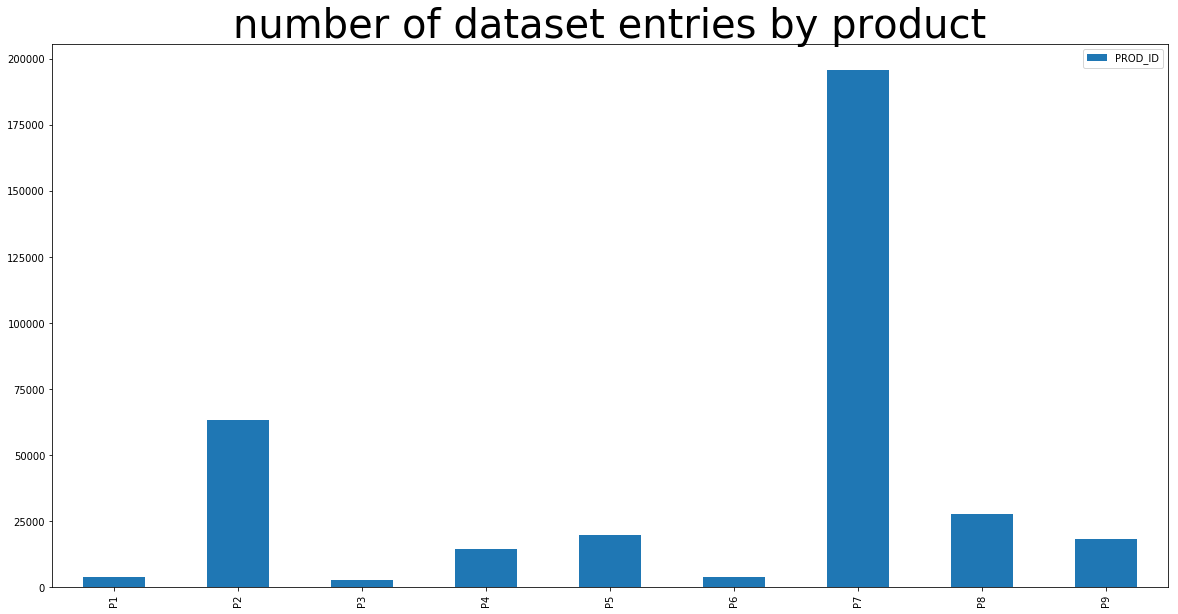

In [7]:
sales_df[["PROD_ID"]].apply(pd.value_counts).sort_index().plot(kind='bar',figsize=(20,10), title="number of dataset entries by product")
fig = plt.gcf()
fig.axes[0].title.set_size(40)

comments: data is a little bit unbalanced. There's much more data for P7 and P2 is a distant second place, while the others and much lower.

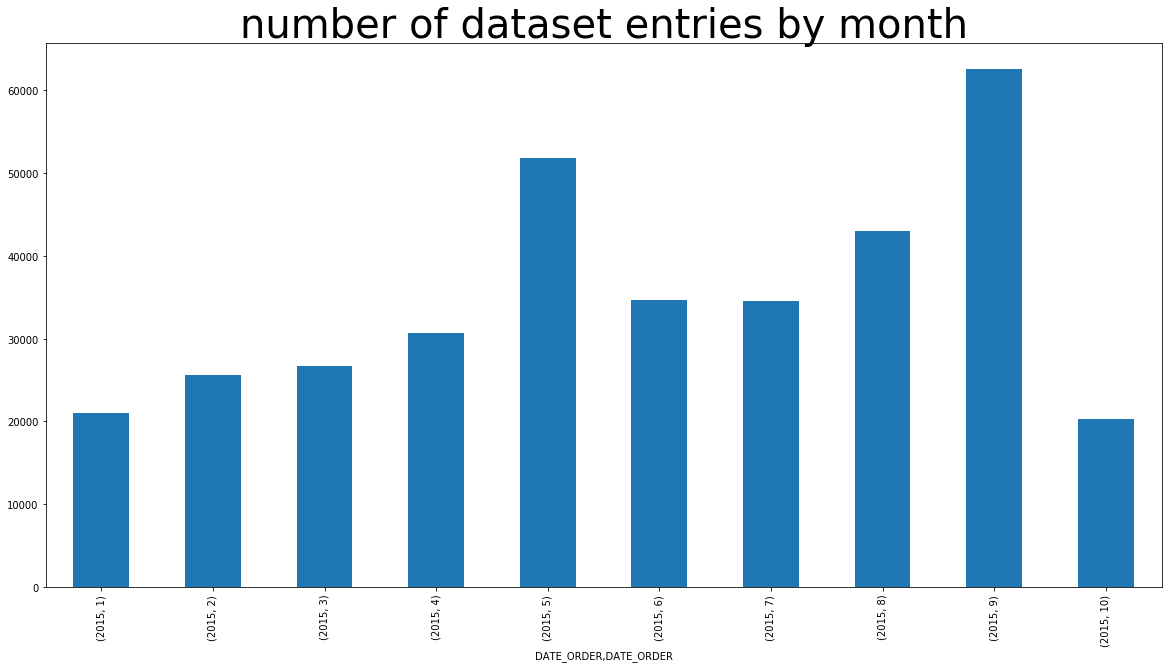

In [8]:
sales_df[["DATE_ORDER"]].groupby([sales_df.DATE_ORDER.dt.year,sales_df.DATE_ORDER.dt.month]).size().plot(kind="bar",figsize=(20,10), title="number of dataset entries by month")
fig = plt.gcf()
fig.axes[0].title.set_size(40)

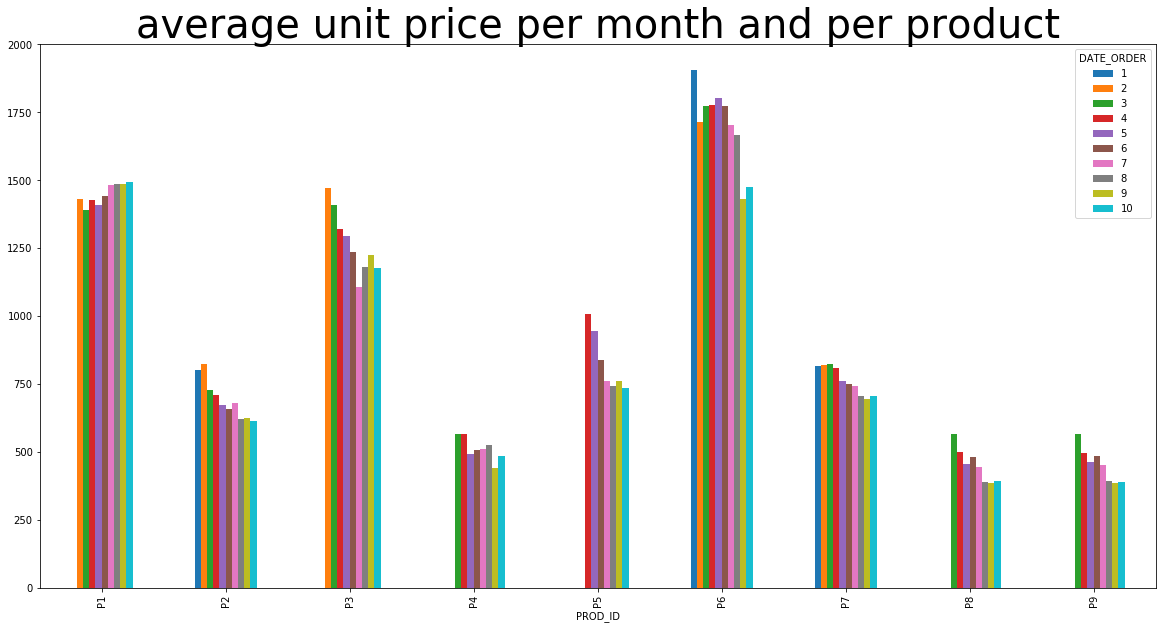

In [9]:
# assuming the UNIT_PRICE for a product is given by REVENUE / QTY_ORDER
# let's create a new column
sales_df["UNIT_PRICE"] = sales_df["REVENUE"] / sales_df["QTY_ORDER"]
sales_df.groupby(sales_df["PROD_ID"])

# `.unstack` pivots the inner aggregations so that I can plot every month in a single month
sales_df.groupby([sales_df.PROD_ID,sales_df.DATE_ORDER.dt.month])["UNIT_PRICE"].mean().unstack('DATE_ORDER').plot(kind='bar',figsize=(20,10),title='average unit price per month and per product')
fig = plt.gcf()
fig.axes[0].title.set_size(40)

# no scientific notation
ax = plt.gca()
ax.yaxis.major.formatter.set_scientific(False)

comments: the unit price for each product has remained relatively stable over the months

(0, 1]      335015
(1, 2]       12294
(2, 3]        1475
(3, 4]         499
(4, 5]        1302
(5, inf]       506
Name: QTY_ORDER, dtype: int64


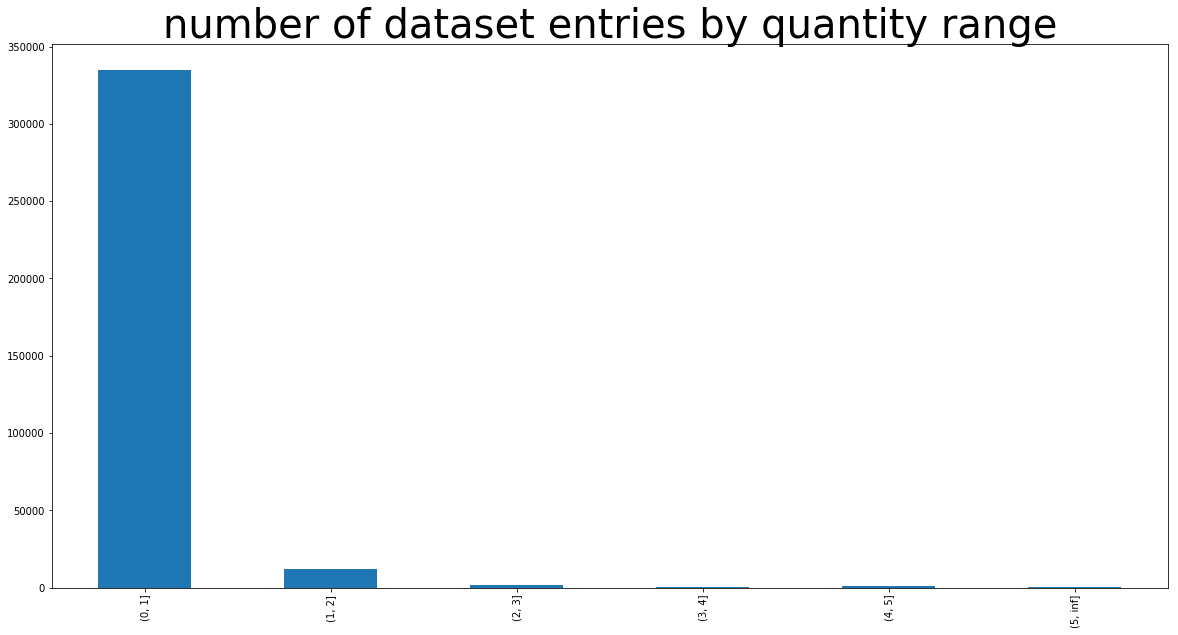

In [10]:
vc=pd.value_counts(pd.cut(sales_df["QTY_ORDER"],bins=[0,1,2,3,4,5,np.inf]))
vc.sort_index().plot(kind='bar',figsize=(20,10), title="number of dataset entries by quantity range")
print(vc.sort_index())
fig = plt.gcf()
fig.axes[0].title.set_size(40)

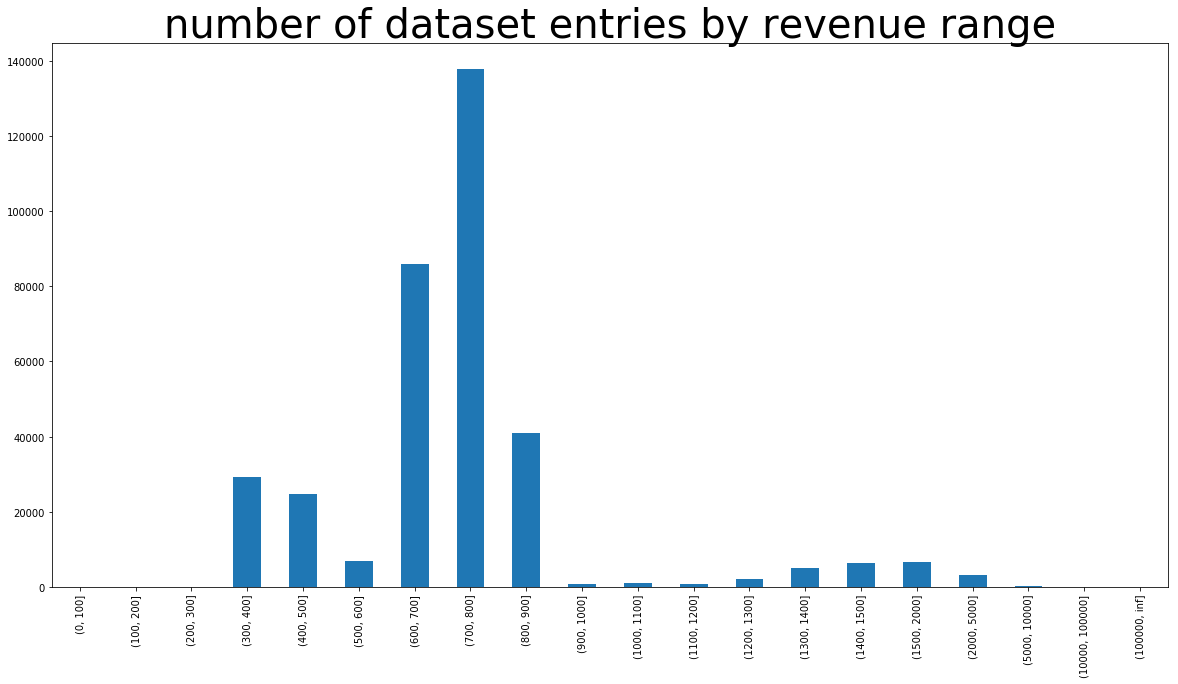

In [11]:
fig = plt.gcf()
vc=pd.value_counts(pd.cut(sales_df["REVENUE"],bins=[0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,2000,5000,10000,100000,np.inf]))
vc.sort_index().plot(kind='bar',figsize=(20,10), title="number of dataset entries by revenue range")
fig.axes[0].title.set_size(40)

comments: revenues are mostly concentrated in the 300 - 900 range.

### totals per product, per month

In [12]:
sales_df.groupby([sales_df.PROD_ID, sales_df.DATE_ORDER.dt.month]).sum()

QTY_ORDER      REVENUE   UNIT_PRICE
PROD_ID DATE_ORDER                                     
P1      2             307.000   436424.720   410464.410
        3             791.000  1100141.380  1080793.380
        4             354.000   505790.410   498695.410
        5             666.000   938421.960   926715.150
        6             503.000   726061.930   718866.930
        7             478.000   709417.910   700423.910
        8             341.000   506840.380   499630.190
        9             504.000   749076.150   734161.100
        10            229.000   341921.900   329929.900
P2      1            4228.000  3379743.290  3294592.530
        2            2286.000  1878595.040  1828612.870
        3            7799.000  5671868.610  5415490.800
        4           10664.000  7561514.400  7248662.340
        5           10355.000  6959280.150  6444727.600
        6            6753.000  4441458.200  4214531.860
        7            3654.000  2475906.890  2385347.680
        8           10502.000  6461727.960  5678858.520
        9            9032.000  5629908.830  5362136.290
        10           2571.000  1557481.820  1303694.770
P3      2             149.000   219296.580   217797.580
        3             565.000   795431.120   786836.920
        4             409.000   540607.560   539308.560
        5             359.000   464140.920   457721.890
        6             253.000   312887.560   306612.020
        7             811.000   898459.450   873171.450
        8             153.000   180642.840   177097.740
        9             193.000   235685.090   230195.090
        10             57.000    67018.830    65851.870
P4      3              22.000    12432.650    12432.650
        4            1703.000   961363.250   910544.150
...                       ...          ...          ...
P6      7             169.000   287664.360   280873.720
        8             181.000   301820.870   293444.010
        9             977.000  1396235.990  1299066.960
        10            202.000   297797.500   285883.500
P7      1           17501.000 14286786.250 13562759.230
        2           23390.000 19161745.390 17976148.950
        3           18599.000 15237796.310 13977005.670
        4           17435.000 14104482.340 13089344.490
        5           32743.000 24857731.170 22726402.980
        6           25399.000 19014895.850 17322772.070
        7           23711.000 17599940.730 16495412.140
        8           18411.000 12980475.010 12032092.560
        9           27822.000 19284461.620 17959593.580
        10           6711.000  4713827.050  4335022.210
P8      3             190.000   107138.630   103245.130
        4             929.000   462064.220   442102.120
        5            3144.000  1428978.150  1377675.920
        6            1520.000   729738.420   705116.920
        7            2532.000  1121301.590  1053317.920
        8            6983.000  2695647.680  2466631.210
        9            9557.000  3674420.640  3435114.120
        10           4965.000  1938391.080  1793987.890
P9      3             141.000    79530.960    77907.670
        4             663.000   328203.770   321424.630
        5            2251.000  1038811.180  1005885.800
        6             575.000   278084.050   254873.400
        7             512.000   231101.680   224812.070
        8            5764.000  2259495.610  2081698.920
        9            7160.000  2753604.280  2585872.460
        10           2595.000  1010070.000   944374.890

[79 rows x 3 columns]

comments: there's not data for all products on every month

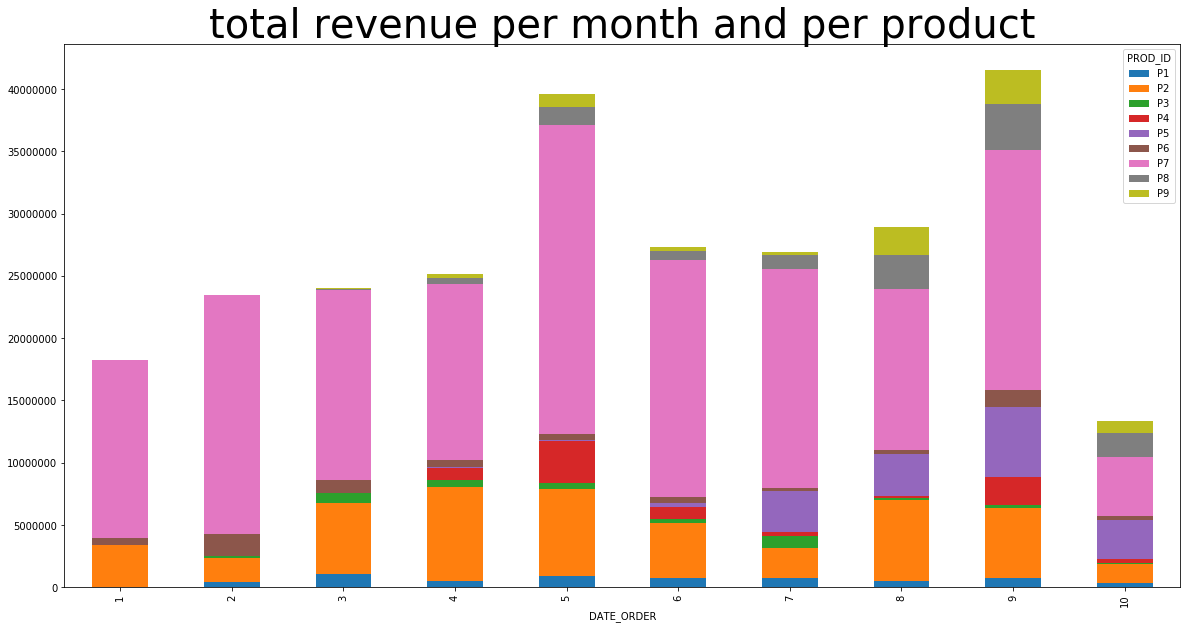

In [13]:
sales_df.groupby([sales_df.DATE_ORDER.dt.month, sales_df.PROD_ID])["REVENUE"].sum().unstack('PROD_ID').plot(kind='bar',stacked=True,figsize=(20,10),title='total revenue per month and per product')
fig = plt.gcf()
fig.axes[0].title.set_size(40)

# no scientific notation
ax = plt.gca()
ax.yaxis.major.formatter.set_scientific(False)

comments: confirming previous thoughts, P7 accounts for a large share of revenue, followed by P2

# exploring comp_prices.csv

In [14]:
comp_df = pd.read_csv('../data/raw/comp_prices.csv')
comp_df.DATE_EXTRACTION = comp_df.DATE_EXTRACTION.astype("datetime64")
comp_df.PAY_TYPE = comp_df.PAY_TYPE.astype(str)

In [15]:
print("{0} rows".format(len(comp_df)))
comp_df.head()

50114 rows


,PROD_ID,DATE_EXTRACTION,COMPETITOR,COMPETITOR_PRICE,PAY_TYPE
0,P6,2015-01-30 08:11:38,C3,1898.000,1
1,P6,2015-01-30 08:11:38,C1,1898.000,1
2,P6,2015-01-30 08:11:38,C6,1999.900,1
3,P6,2015-01-31 20:10:14,C2,1894.880,2
4,P6,2015-01-31 20:10:14,C3,1894.880,2


In [16]:
start = comp_df["DATE_EXTRACTION"].min()
end = comp_df["DATE_EXTRACTION"].max()

print("data started and stopped being collected on {0} and {1}, respectively.".format(start.strftime("%d/%m/%Y"),end.strftime("%d/%m/%Y")))

data started and stopped being collected on 01/01/2015 and 14/10/2015, respectively.


In [17]:
# PROD_ID,DATE_EXTRACTION, COMPETITOR and PAY_TYPE are categorical fields
comp_df.groupby([comp_df.COMPETITOR,comp_df.PROD_ID]).describe(percentiles=[.10,.25, .5, .75,.90,.95,.99,.999,.9999])

COMPETITOR_PRICE
COMPETITOR PROD_ID                         
C1         P1      count            765.000
                   mean            1871.916
                   std             7140.431
                   min             1090.000
                   10%             1319.120
                   25%             1396.900
                   50%             1469.020
                   75%             1499.000
                   90%             1899.000
                   95%             1899.000
                   99%             1899.000
                   99.9%         136157.168
                   99.99%        148525.717
                   max           149900.000
           P2      count           1122.000
                   mean             832.437
                   std             2881.658
                   min              539.100
                   10%              610.000
                   25%              652.987
                   50%              699.000
                   75%              786.997
                   90%              828.000
                   95%              829.000
                   99%              829.900
                   99.9%          57459.351
                   99.99%         71685.275
                   max            72498.000
           P3      count           1646.000
                   mean            1328.234
...                                     ...
C6         P7      99.99%           879.000
                   max              879.000
           P8      count           1149.000
                   mean             533.014
                   std             1649.063
                   min              399.990
                   10%              428.000
                   25%              439.000
                   50%              469.000
                   75%              493.980
                   90%              497.980
                   95%              509.000
                   99%              534.990
                   99.9%          34158.624
                   99.99%         39999.000
                   max            39999.000
           P9      count           1137.000
                   mean             533.670
                   std             1657.731
                   min              399.990
                   10%              428.000
                   25%              439.000
                   50%              469.000
                   75%              493.780
                   90%              495.958
                   95%              525.000
                   99%              535.634
                   99.9%          34632.168
                   99.99%         39999.000
                   max            39999.000

[644 rows x 1 columns]

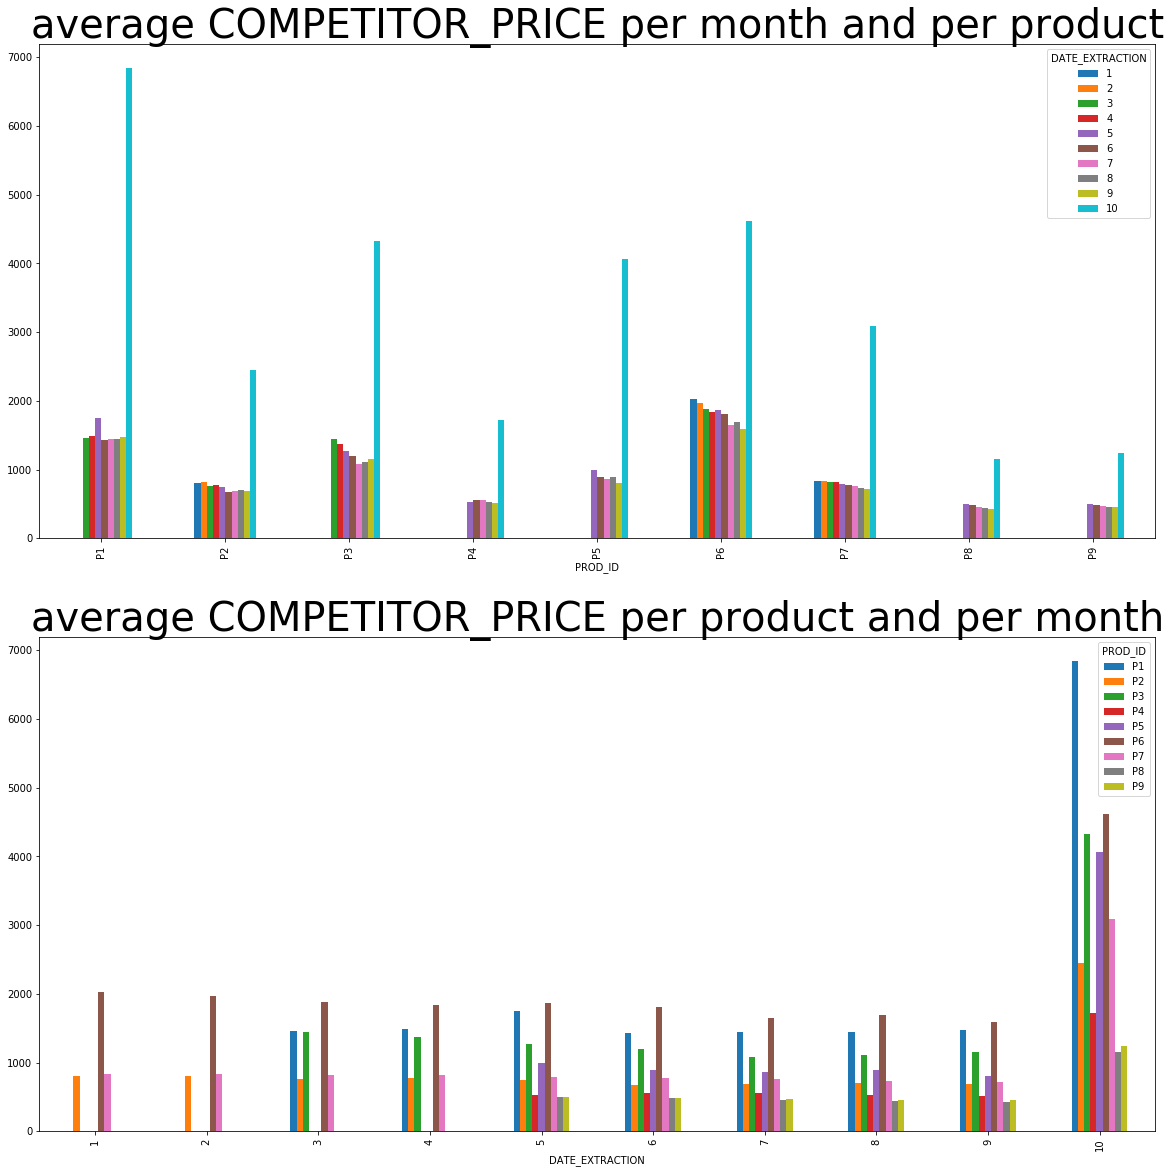

In [18]:
# what's the average price per product, per month?
fig, axes = plt.subplots(2,1,figsize=(20,20))
comp_df.groupby([comp_df.PROD_ID,comp_df.DATE_EXTRACTION.dt.month])["COMPETITOR_PRICE"].mean().unstack('DATE_EXTRACTION').plot(kind='bar',ax=axes[0], title='average COMPETITOR_PRICE per month and per product')
axes[0].title.set_size(40)

# and the average price per month, per product?
comp_df.groupby([comp_df.PROD_ID,comp_df.DATE_EXTRACTION.dt.month])["COMPETITOR_PRICE"].mean().unstack('PROD_ID').plot(kind='bar',ax=axes[1], title='average COMPETITOR_PRICE per product and per month')
axes[1].title.set_size(40)

comments: Average prices for all products are very stable but there's been a massive increase in the average price across all products in the last month. Also, there's not data for every product in every month.

> I wonder if the massive increase in the last month is consistent across all COMPETITORS? what about PAY_TYPES?

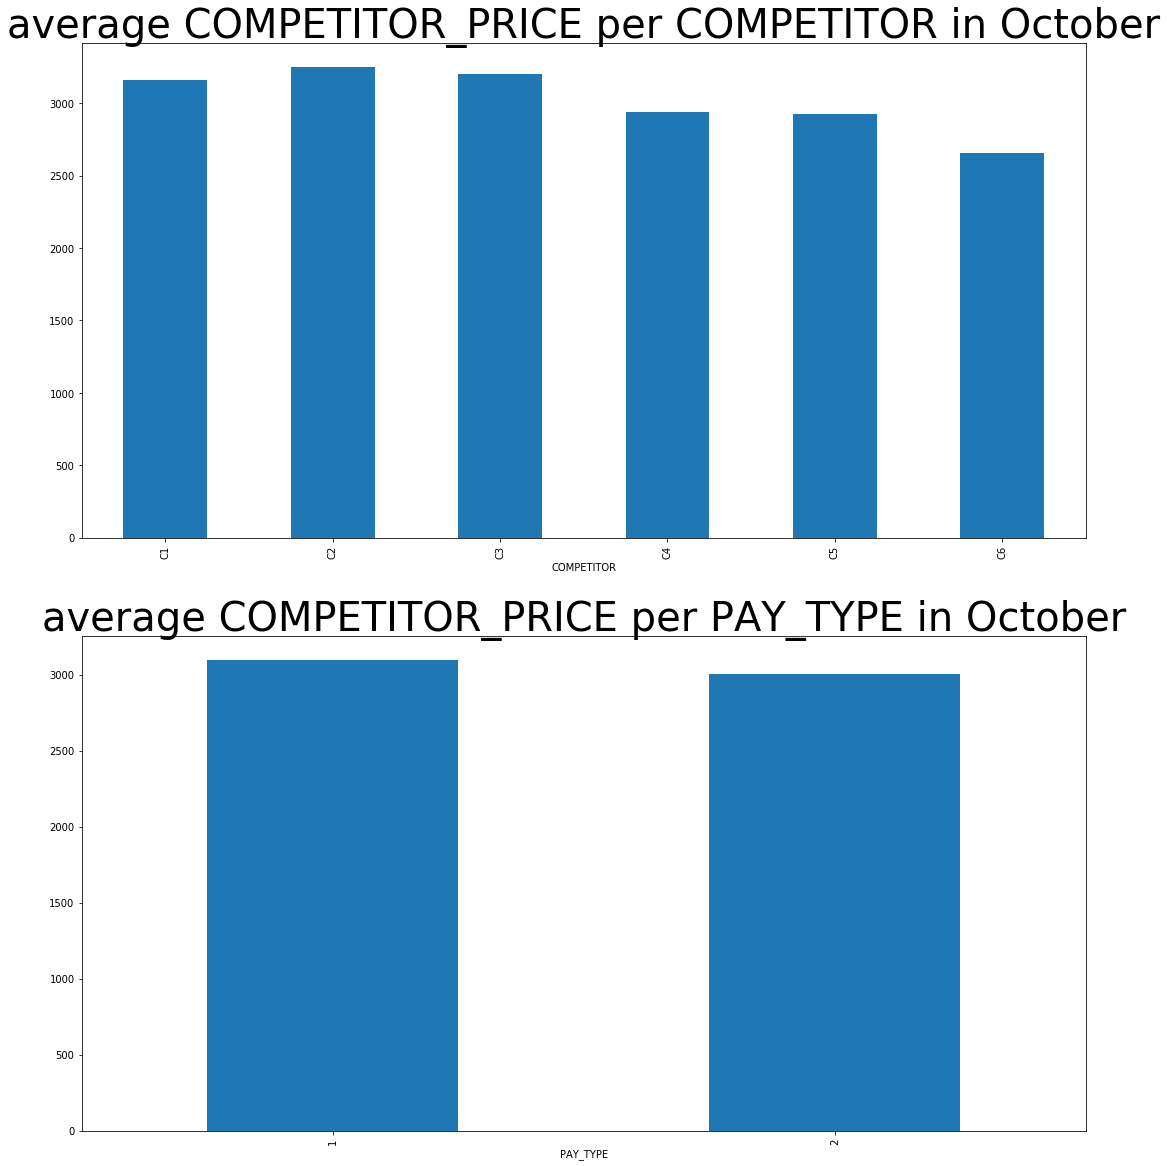

In [19]:
fig, axes = plt.subplots(2,1,figsize=(18,20))
comp_df[comp_df.DATE_EXTRACTION.dt.month == 10].groupby([comp_df.COMPETITOR])["COMPETITOR_PRICE"].mean().plot(kind='bar',ax=axes[0], title='average COMPETITOR_PRICE per COMPETITOR in October')
axes[0].title.set_size(40)


comp_df[comp_df.DATE_EXTRACTION.dt.month == 10].groupby([comp_df.PAY_TYPE])["COMPETITOR_PRICE"].mean().plot(kind='bar',ax=axes[1], title='average COMPETITOR_PRICE per PAY_TYPE in October')
axes[1].title.set_size(40)

comments: the rise in the mean price is consistent across all competitors and all pay types

> what about the price for each day on the month the prices went up? Maybe it was only in a couple days

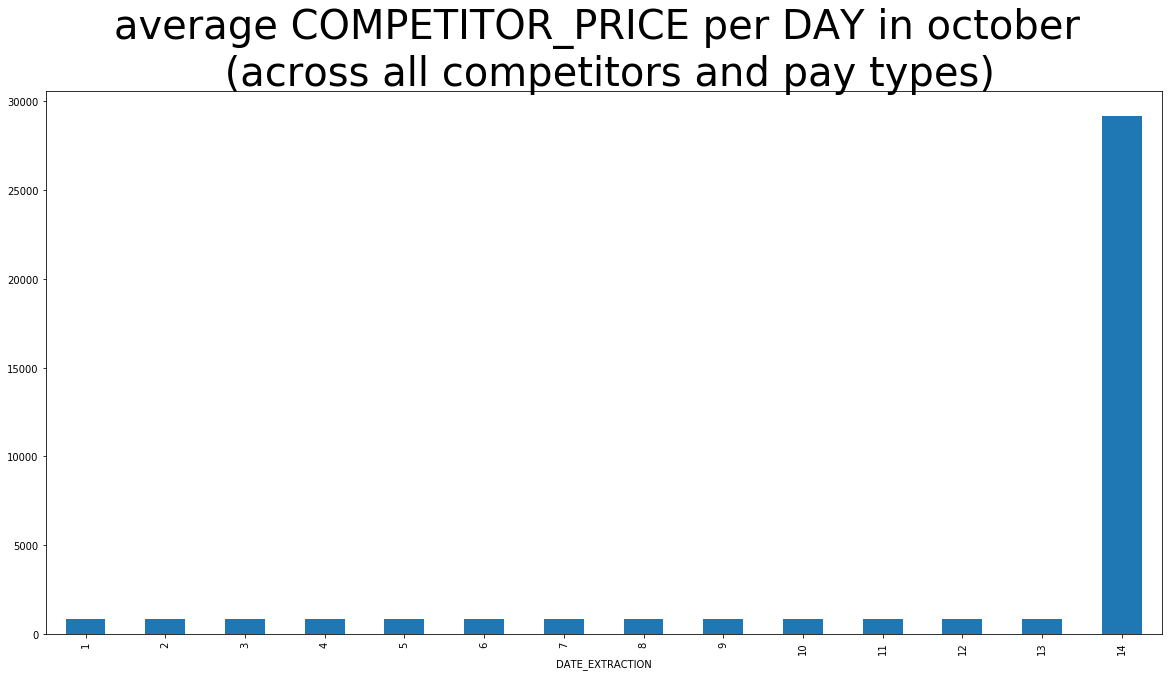

In [20]:
comp_df[comp_df.DATE_EXTRACTION.dt.month == 10].groupby([comp_df.DATE_EXTRACTION.dt.day])["COMPETITOR_PRICE"].mean().plot(kind='bar',figsize=(20,10), title='average COMPETITOR_PRICE per DAY in october \n (across all competitors and pay types)')
fig = plt.gcf()
fig.axes[0].title.set_size(40)

comments: the rise in price observed in october was due to a single day, 14.

> Maybe we can learn something more about it.

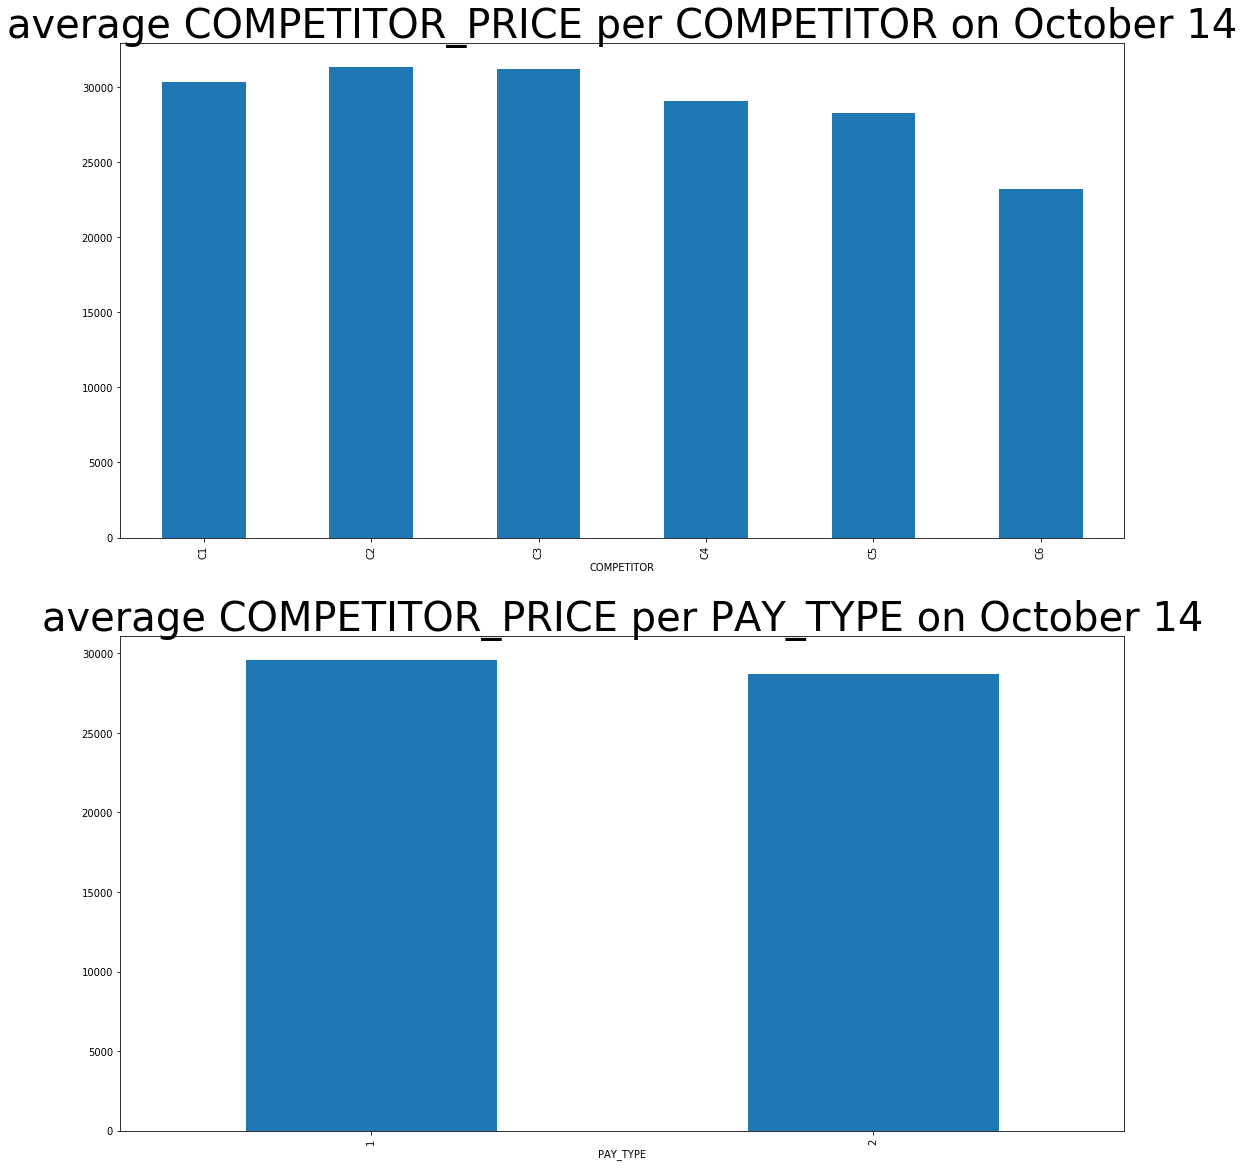

In [21]:
fig, axes = plt.subplots(2,1,figsize=(18,20))

comp_df[(comp_df.DATE_EXTRACTION.dt.month == 10) & (comp_df.DATE_EXTRACTION.dt.day == 14)].groupby([comp_df.COMPETITOR])["COMPETITOR_PRICE"].mean().plot(kind='bar',ax=axes[0], title='average COMPETITOR_PRICE per COMPETITOR on October 14')
fig.axes[0].title.set_size(40)

comp_df[(comp_df.DATE_EXTRACTION.dt.month == 10) & (comp_df.DATE_EXTRACTION.dt.day == 14)].groupby([comp_df.PAY_TYPE])["COMPETITOR_PRICE"].mean().plot(kind='bar',ax=axes[1], title='average COMPETITOR_PRICE per PAY_TYPE on October 14')
fig.axes[1].title.set_size(40)

comments: again the increase in price in the 14th of October has been observed across ALL competitors and ALL pay types so the first thing I would try next is to look at the price extraction crawlers and see if there was anything unusual on that day.

Either way, it looks like it's better to remove all data from October 14 from the dataset before doing out analysis, as we will have a faulty model if we train it or test it on bad data.


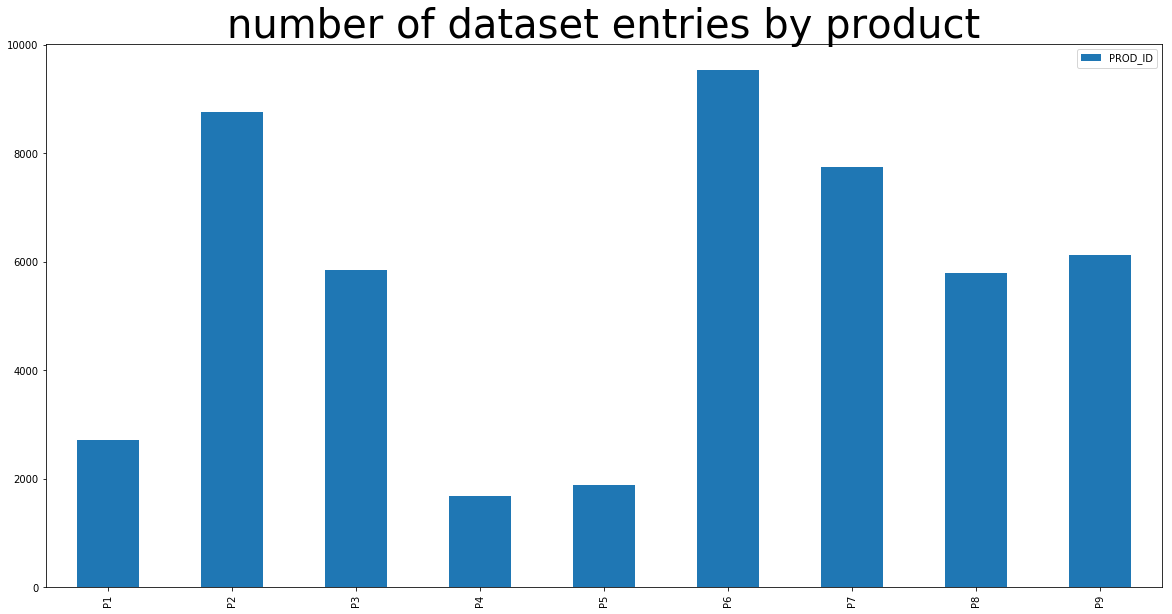

In [22]:
comp_df[["PROD_ID"]].apply(pd.value_counts).sort_index().plot(kind='bar',figsize=(20,10), title="number of dataset entries by product")
fig = plt.gcf()
fig.axes[0].title.set_size(40)

comments: there's not much data for P1, P4 and P5 

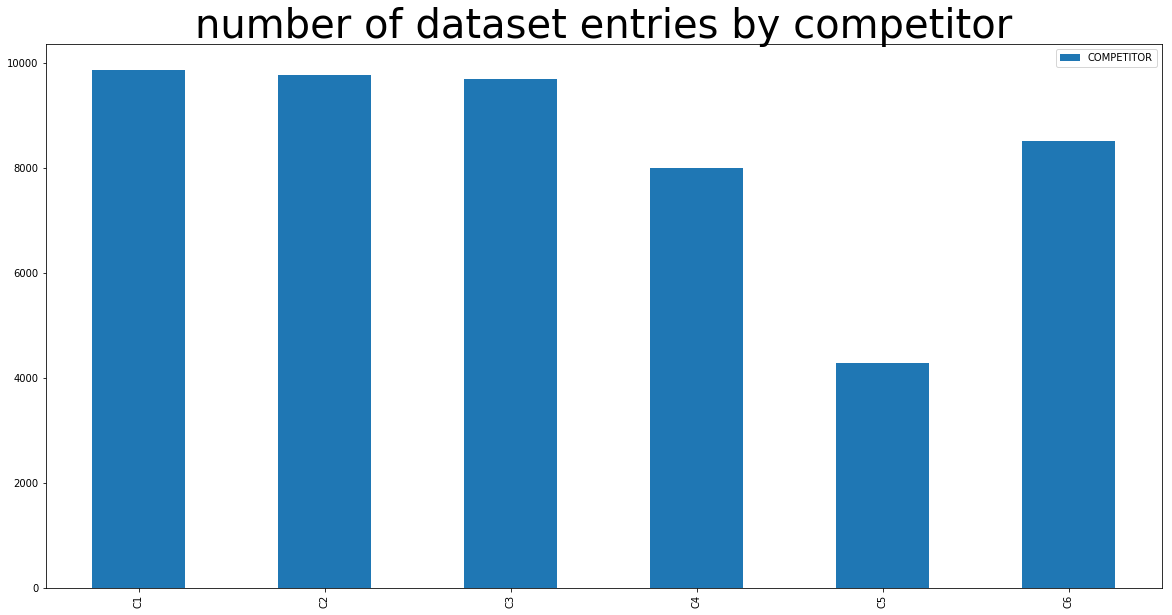

In [23]:
comp_df[["COMPETITOR"]].apply(pd.value_counts).sort_index().plot(kind='bar',figsize=(20,10), title="number of dataset entries by competitor")
fig = plt.gcf()
fig.axes[0].title.set_size(40)

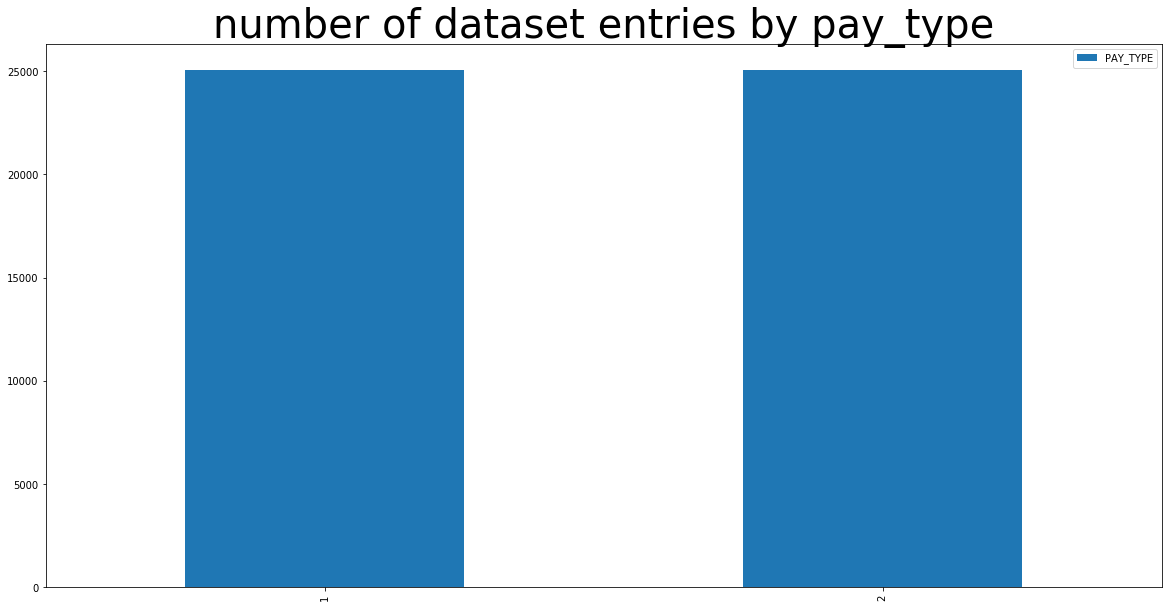

In [24]:
comp_df[["PAY_TYPE"]].apply(pd.value_counts).sort_index().plot(kind='bar',figsize=(20,10), title="number of dataset entries by pay_type")
fig = plt.gcf()
fig.axes[0].title.set_size(40)